## Preamble (Optional)

### Chain Rule
Take any old distribution
$$p(x_1, \ldots, x_n)$$
The chain rule states
$$ p(x_1, \ldots, x_n) = \prod_{i=1}^n p(x_i ~|~ x_1, \ldots, x_{i-1}) = \prod_{i=1}^n p(x_i ~|~ x_{< i})$$
The nifty thing about this is that we can use it to represent any possible distribution, as a table, for example consider representing the joint probability distribution of 2 bernoulli random variables
$$
\begin{pmatrix}
p(x_1 = 1) & p(x_1 = 0)\\
p(x_2 = 1 | x_1 = 1) & p(x_2 = 1 | x_1 = 1) & p(x_2 = 0 | x_1 = 1) & p(x_2 = 0 | x_1 = 0)
\end{pmatrix}
$$
And immediately we see the problem, the table explodes at rate $d^n$, where $d$ is the number of possible values a random variable can have and $n$ is the number of random variables, but thats kinda close to what we want for a generator model. We want to learn some distribution of the training data, and to emulate that, so we want some discounted version of that table ^^, which doesn't take up so much space

### Bernoulli Simplification
Instead of filling out a table consider a function like this
$$p_{\theta_i}(x_i ~|~ x_{< i}) = Bern(f(x_{<i})$$
Which maps the conditional distribution to some output between 0 and 1
$$p_{\theta_i}(x_i ~|~ x_{< i}) \to Bern(f(x_{<i})) \in \{0, 1\}$$

### Imports and Dataloaders
None of this is all that important its just getting the a dataset, and transforming the data to make it more ammenable to low compute resources

In [1]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
from barbar import Bar

In [2]:
# we want the image values to be between 0 and 1, and we we want them to be tensors
# resize the images to be 18 by 18 to make the generation process easier
trans = transforms.Compose([transforms.Grayscale(), transforms.Resize((18,18)), transforms.ToTensor()])
mnist_loader = torch.utils.data.DataLoader(datasets.MNIST(root='./data', train=True, download=True, 
                                                          transform=trans), shuffle=True)
MNIST_SIZE = 18 
device = torch.device("cuda:0")

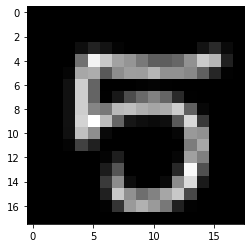

In [3]:
idx, (img, label) = next(enumerate(mnist_loader))
plt.imshow(img[0][0], cmap='gray', interpolation='none')

### Fully Visible Sigmoid Belief Network (FVSBN)
Using the above **Bernoulli Simplification** choose, 
$$f(x_{x<i}) = \sigma(\alpha \cdot x_1 + \ldots + \alpha \cdot x_{i-1}) \tag{1}$$
Where
$$\sigma(x) = \frac{1}{1 + e^{x}}$$

### FVSBN in Practice
Now lets apply this to MNIST. 

**Data Prep**

Our method does not use convolution, it takes the input image as a vector
$$
\begin{pmatrix}
x_{1,1} & \ldots & x_{1, 28}\\
\vdots & \vdots & \vdots \\
x{28, 1} & \ldots & x_{28, 28}
\end{pmatrix} 
\to
\begin{pmatrix}
x_{1,1} & \ldots & x_{28, 28}\\
\end{pmatrix} 
$$
Additionally our model is trying to predict if a pixel is 0 or 1, so the input vector is binarized

**Generation**

Our function 
$$f(x_{x<i}) = \sigma(\alpha \cdot x_1 + \ldots + \alpha \cdot x_{i-1})$$
is supposed to predict the *ith* pixel as a result of the previous set of pixels (this is why the method is called *autoregressive*. 

Fitting a model to learn $\alpha$ involves training $dim(image)^2$ linear layers in a neural net. The first layer predicting $pixel_{1,2}$, the last layer predicting $pixel_{28, 28}$. Note *what about the first pixel*. The first pixel has no prior and thus is chosen at random from the domain which in this case is just $\{0, 1\}$. Note that our function (1), returns the *probability* that a given pixel value 1, thus 

$$pixel_{i} = Bern(f(x_{x<i}))$$


**Discrimination/ Loss**
But how do you tell if the generated output is any good or not? The simplest course of action is to compute the log likelihood, that is, if our guess or generated output is $Bern(f(x_{x<i}))$, and the ground truth value, or the pixel value observed in that particular training image is $\overline{\text{pixel i}}$, then the log likelihood is
$$
\text{log likelihood}(\overline{\text{pixel i}}) = \overline{\text{pixel i}} * \log_e(Bern(f(x_{x<i})) + \epsilon) + (1 - \overline{\text{pixel i}}) * \log_e(1 - Bern(f(x_{x<i})) + \epsilon)
\tag{2}
$$

So lets break down what (2) is doing and why we need $\epsilon$.

Our generator is either correct or not correct. So lets see what happens when its correct
- (pixel i = 1, guess $\approx$ 1) or (pixel i= 0, guess $\approx$ 0). in either of these cases we return something which is pretty close to 0, which for loss means, hey we did a pretty good job with guessing that pixel

When we are wrong though
- (pixel i = 1, guess $\not =$ 1) or (pixel i= 0, guess $\not =$ 0) we get the opposite effect. The further our guess is away from being correct the smaller thing we are taking the logarithm of, which is where $\epsilon$ comes into play. If we wanan make sure our $\log_e$ doesn't spit out infinity we have to add an additionally small term onto to our guess to make it ever so slighly greater than 0.

Now our loss at the moment is only being measured on a per pixel basis, we want to sum over all the pixels, giving a net loss looking something like 
$$\sum_{i=2}^{\text{dim(image)}} \text{log likelihood}(\overline{\text{pixel i}}) \tag{3}$$

In [28]:
epsilon = torch.Tensor([1e-10]).to(device)
def log_pmf(pixel_val, guess):
    '''
    equation (2) from above
    
    note that this takes the probability that a pixel is 1 (guess), not the pixel value itself
    
    pixel val is the ground truth value
    '''
    guess = guess.to(device)
    return pixel_val * torch.log(guess + epsilon) + (1. - pixel_val) * torch.log(1. - guess + epsilon)

In [5]:
class FVSBN(nn.Module):
    def __init__(self):
        super(FVSBN, self).__init__()
        
        # each of these layers represents the inner bit of equation (1)
        layers = []
        for i in range(1, MNIST_SIZE**2):
            layers += [nn.Linear(i, 1)]
        
        self.models = nn.Sequential(*layers)
        
        # HACK (almost all the MNIST images have a first pixel 
        # value of 0)
        self.x1 = torch.Tensor([0])
    
    def forward(self, image):
        
        # DATA PREP
        # flatten out our image mat into a vector
        image = image.view(-1, MNIST_SIZE**2)
        # binarize our our image vector
        image = torch.where(image < 0.5, torch.tensor(0.).to(device), torch.tensor(1.).to(device))
        
        # setting the first pixel
        # we do this outside the loop because we have no weight matrix for it
        probability = torch.sigmoid(self.x1)
        logpx = log_pmf(image[:, 0:1], probability)
        
        # generating the rest of our pixels using our learned weights
        # note:
        #   next x represents using eq (1) - generating the ith pixel
        #   predictated on pixels [0, i-1] (slicing in python is non inclusive thats why it says i)
        
        # then using eq (3) to calculate our loss on this image generation
        for i in range(1, MNIST_SIZE**2):
            next_x = torch.sigmoid(self.models[i-1](image[:, 0:i]))
            logpx += log_pmf(image[:, i:i+1], next_x)
        
        return logpx
    
    def sample(self):
        with torch.no_grad():
            # always set our initial pixel to be 0
            initial_pixel = self.x1
            complete_image = torch.zeros(1, MNIST_SIZE**2, device=device)
            complete_image[:, 0:1] = initial_pixel
            
            # as mentioned before, now that the model is fit
            # to eq (1), we use this weights to guess the subsequent pixels
            # only difference is there is no ground truth (its a made up image)
            
            # bernouilli(p) => return 1 with probability p, and return 0 with probability 1-p
            for i in range(1, MNIST_SIZE**2):
                ith_pixel_probability = torch.sigmoid(self.models[i-1](complete_image[:, 0:i]))
                predicted_pixel = torch.bernoulli(ith_pixel_probability)
                complete_image[:, i:i+1] = predicted_pixel
        # reshape image back into a vector
        return complete_image.view(18, 18)

In [29]:
# the number of parameters of the first layer (for the second pixel) is only 1, the only weight is the first
# pixel, for the second layers its 2, and so on and so forth, for the nth layer the number of parameters (alphas)
# is equal to n-1

# thus the number of learnable paramerters is 1 + 2 + ... + number of pixels in the image 

# +1 because range is not inclusive
print("The number of learnable parameters for this model being {}".format(sum(range(1, MNIST_SIZE**2 + 1))))

The number of learnable parameters for this model being 52650


### Training

In [7]:
fvsbn = FVSBN()

In [12]:
def train(net, device, trainloader, num_epochs=10):
    net = net.to(device)
    optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
    img_list = []
    
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0
        for i, data in enumerate(Bar(trainloader)):
            image, labels = data[0].to(device), data[1].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            log_likelihood = fvsbn(image)
            loss = -1 * log_likelihood
            running_loss += loss
            loss.backward()
            optimizer.step()
            
            if i % 100 == 0:
                sample_img = net.sample()
                img_list.append(sample_img)
            
            if i == 1000:
                break
            
    return net, img_list

In [13]:
finished_net, img_list = train(fvsbn, device, mnist_loader, 1)

 1001/60000: [>...............................] - ETA 8045.8s

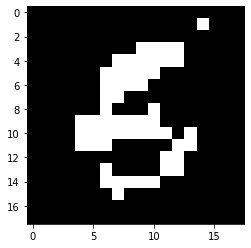

In [27]:
plt.imshow(img_list[8].cpu(), cmap='gray', interpolation='none')

### References
- [Bayesian Networks @ Cal](https://inst.eecs.berkeley.edu/~cs188/sp12/slides/cs188%20lecture%2013%20and%2014%20--%20bayes%20nets%20representation%20and%20independence%202PP.pdf)
- [Autoreggressive Models @ Stanford](https://deepgenerativemodels.github.io/assets/slides/cs236_lecture3.pdf)
- [Keras Code](https://nbviewer.jupyter.org/github/ilguyi/generative.models.tensorflow.v2/blob/master/autoregressive/fvsbn.ipynb)